# Adversarial Variational Optimization: Poisson benchmark

This notebook shows the usage of `hypothesis` with `AVO` (Adversarial Variational Optimization) on the Poisson benchmark. In this inference setting, the goal is to obtain the model parameter $\mathbf{\theta}*$ that is responsible for generating $\mathbf{x}_o \sim p(\mathbf{x}|\mathbf{\theta})$.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

First, we need to be in the possesion of some $\mathbf{x}_o$:

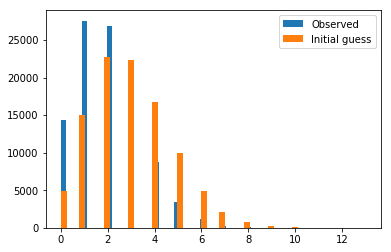

In [2]:
from hypothesis.benchmark.poisson import allocate_observations

theta_true, x_o = allocate_observations(1.95)

# Show some observation, with some initial guess.z
plt.hist(x_o.numpy(), bins=50, label="Observed")
plt.hist(allocate_observations(3.)[1].numpy(), bins=50, label="Initial guess")
plt.legend()
plt.show()

Clearly, our initial guess is completely wrong.

## Utility methods

In [3]:
def plot_proposal(proposal):
    mean = proposal._mu.item()
    sigma = proposal._sigma.item()
    true = theta_true.item()
    x = np.linspace(mean - 15 * sigma, mean + 15 * sigma + 1.5, 5000)
    plt.axvline(true, linestyle="--", c="lightgray", label=r"${\theta^*}$")
    plt.plot(x, mlab.normpdf(x, mean, sigma), label=r"$q({\theta}|{\psi})\ \gamma = 0$")
    plt.xlim([0, np.max(x)])
    plt.grid(False)
    plt.legend()
    plt.show()

## AVO

### Discriminator

In [4]:
def allocate_discriminator():
    num_hidden = 50
    discriminator = torch.nn.Sequential(
        torch.nn.Linear(1, num_hidden),
        torch.nn.PReLU(),
        torch.nn.Linear(num_hidden, num_hidden),
        torch.nn.PReLU(),
        torch.nn.Linear(num_hidden, num_hidden),
        torch.nn.PReLU(),
        torch.nn.Linear(num_hidden, num_hidden),
        torch.nn.PReLU(),
        torch.nn.Linear(num_hidden, 1),
        torch.nn.Sigmoid()
    )
    
    return discriminator

### Simulator

In [5]:
from hypothesis.benchmark.poisson import PoissonSimulator as Simulator

simulator = Simulator()

### Proposal

In [6]:
from hypothesis.proposal import NormalProposal

proposal = NormalProposal()

### Inference

In [7]:
from hypothesis.inference import AdversarialVariationalOptimization

avo = AdversarialVariationalOptimization(simulator, allocate_discriminator(), proposal)

In [8]:
proposal = avo.infer(x_o, steps=10000)

/home/joeri/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


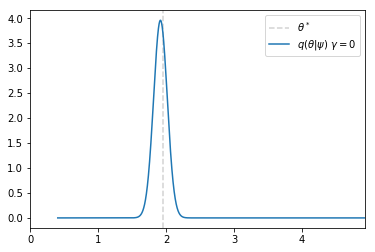

In [9]:
plot_proposal(proposal)

## AVO Ensembles

In [10]:
num_runs = 15
results = []

for run in range(num_runs):
    print("Executing run", (run + 1))
    proposal = NormalProposal()
    avo = AdversarialVariationalOptimization(simulator, allocate_discriminator(), proposal)
    results.append(avo.infer(x_o, steps=10000))

Executing run 1
Executing run 2
Executing run 3
Executing run 4
Executing run 5
Executing run 6
Executing run 7
Executing run 8
Executing run 9
Executing run 10
Executing run 11
Executing run 12
Executing run 13
Executing run 14
Executing run 15


/home/joeri/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


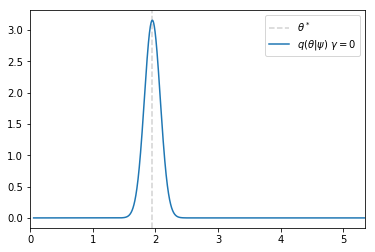

In [16]:
with torch.no_grad():
    mu = 0.
    sigma = 0.
    for proposal in results:
        mu += proposal._mu
        sigma += proposal._sigma
    mu /= num_runs
    sigma /= num_runs

averaged_proposal = NormalProposal(mu.detach(), sigma.detach())

plot_proposal(averaged_proposal)